# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.decomposition import TruncatedSVD


In [2]:
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
# Calculate the number of interactions per user
user_interactions = df.groupby('email').size()

# Descriptive statistics
median_val = user_interactions.median()
max_views_by_user = user_interactions.max()

print(f"50% of individuals interact with {median_val} number of articles or fewer.")
print(f"The maximum number of user-article interactions by any one user is {max_views_by_user}.")


50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any one user is 364.


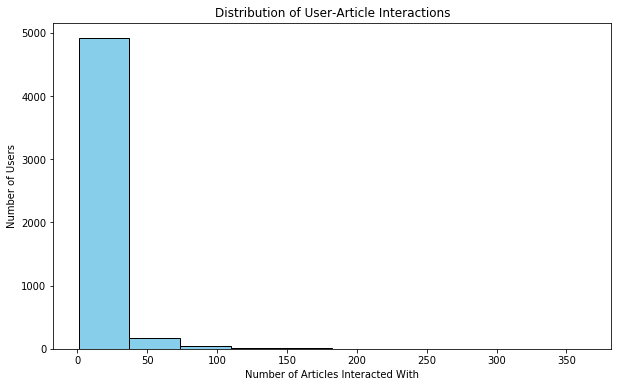

In [5]:
# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(user_interactions, color='skyblue', edgecolor='black')
plt.title('Distribution of User-Article Interactions')
plt.xlabel('Number of Articles Interacted With')
plt.ylabel('Number of Users')
plt.show()

In [6]:
# Fill in the median and maximum number of user_article interactios below

median_val = median_val # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =user_interactions.max()  # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
df_content[df_content.duplicated(['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [8]:
df_content[df_content['article_id']==50]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50


In [9]:
# Remove any rows that have the same article_id - only keep the first

df_content = df_content.drop_duplicates(subset=['article_id'], keep='first')
df_content[df_content.duplicated(['article_id'])]


,doc_body,doc_description,doc_full_name,doc_status,article_id


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:

df[df['article_id'].isin(list(df_content['article_id']))].nunique()

article_id     437
title          437
email         4257
dtype: int64

In [11]:
df_content['article_id'].nunique()


1051

In [12]:
df['article_id'].nunique()

714

In [13]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993  # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [14]:
df.loc[df.groupby('article_id').size().idxmax()]

article_id                                         528
title                10 tips on using jupyter notebook
email         7888dc37498447d0477be7ee2c4176543f5a6190
Name: 1429, dtype: object

In [15]:
df.groupby('article_id').size().max()

937

In [16]:
# Ensure article_id is treated as a string
df['article_id'] = df['article_id'].astype(str)

# Count interactions for each article_id
article_view_counts = df.groupby('article_id').size().reset_index(name='view_count')

# Find the article_id with the maximum view_count
most_viewed_article = article_view_counts.loc[article_view_counts['view_count'].idxmax()]


In [17]:
most_viewed_article_id =most_viewed_article['article_id'] # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [18]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
df['user_id'].nunique()

5149

In [20]:
most_viewed_article_id

'1429.0'

In [21]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [22]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df containing user-article interactions and article titles
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Aggregate interactions by article_id
    article_view_counts = df.groupby('article_id').size().reset_index(name='view_count')
    
    # Sort articles by view_count in descending order and select the top n
    top_articles_df = article_view_counts.sort_values(by='view_count', ascending=False).head(n)
    
    # Merge with df to get article titles
    top_articles_with_titles = pd.merge(top_articles_df, df[['article_id', 'title']], on='article_id', how='left').drop_duplicates('article_id')
    
    # Extract the top article titles
    top_articles = top_articles_with_titles['title'].tolist()
    
    return top_articles



In [23]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df containing user-article interactions
    
    OUTPUT:
    top_article_ids - (list) A list of the top 'n' article ids 
    
    '''
    # Aggregate interactions by article_id
    article_view_counts = df.groupby('article_id').size().reset_index(name='view_count')
    
    # Sort articles by view_count in descending order and select the top n
    top_articles_df = article_view_counts.sort_values(by='view_count', ascending=False).head(n)
    
    # Extract the top article ids
    top_article_ids = top_articles_df['article_id'].tolist()
    
    return top_article_ids


In [24]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [25]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [26]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    # Create the user-item matrix using pivot_table
    user_item = df.pivot_table(index='user_id', columns='article_id', aggfunc=lambda x: 1, fill_value=0)
    
    # Reset index to make 'user_id' a column instead of the index
    
    
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
user_item

title                                                               \
article_id   0.0 100.0 1000.0 1004.0 1006.0 1008.0 101.0 1014.0 1015.0 1016.0   
user_id                                                                         
1              0     0      0      0      0      0     0      0      0      0   
2              0     0      0      0      0      0     0      0      0      0   
3              0     0      0      0      0      0     0      0      0      0   
4              0     0      0      0      0      0     0      0      0      0   
5              0     0      0      0      0      0     0      0      0      0   
6              0     0      0      0      0      0     0      0      0      0   
7              0     0      0      0      0      0     0      0      0      0   
8              0     0      0      0      0      0     0      0      0      0   
9              0     0      0      0      0      0     0      0      0      0   
10             0     0      0      0      0      0     0      0      0      0   
11             0     0      0      0      0      0     0      0      0      0   
12             0     0      0      0      0      0     0      0      0      0   
13             0     0      0      0      0      0     0      0      0      0   
14             0     0      0      0      0      0     0      0      0      0   
15             0     0      0      0      0      0     0      0      0      0   
16             0     0      0      0      0      0     0      0      0      0   
17             0     0      0      0      0      0     0      0      0      0   
18             0     0      0      0      0      0     0      0      0      0   
19             0     0      0      0      0      0     0      0      0      0   
20             0     0      0      0      0      0     0      0      0      0   
21             0     0      0      0      0      0     0      0      0      0   
22             0     0      0      0      0      0     0      0      0      0   
23             0     0      1      0      0      0     0      1      0      0   
24             0     0      0      0      0      0     0      0      0      0   
25             0     0      0      0      0      0     0      0      0      0   
26             0     0      0      0      0      0     1      0      0      0   
27             0     0      0      0      0      0     0      1      0      0   
28             0     0      0      0      0      0     0      0      0      0   
29             0     0      0      0      0      0     0      0      0      0   
30             0     0      0      0      0      0     0      0      0      0   
...          ...   ...    ...    ...    ...    ...   ...    ...    ...    ...   
5120           0     0      0      0      0      0     0      0      0      0   
5121           0     0      0      0      0      0     0      0      0      0   
5122           0     0      0      0      0      0     0      0      0      0   
5123           0     0      0      0      0      0     0      0      0      0   
5124           0     0      0      0      0      0     0      0      0      0   
5125           0     0      0      0      0      0     0      0      0      0   
5126           0     0      0      0      0      0     0      0      0      0   
5127           0     0      0      0      0      0     0      0      0      0   
5128           0     0      0      0      0      0     0      0      0      0   
5129           0     0      0      0      0      0     0      0      0      0   
5130           0     0      0      0      0      0     0      0      0      0   
5131           0     0      0      0      0      0     0      0      0      0   
5132           0     0      0      0      0      0     0      0      0      0   
5133           0     0      0      0      0      0     0      0      0      0   
5134           0     0      0      0      0      0     0      0      0      0   
5135           0     0      0      0      

In [27]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [28]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user

    # sort by similarity

    # create list of just the ids
   
    # remove the own user's id
    # Extract the interaction vector for the given user
    user_vector = user_item.loc[user_id].values
    
    # Compute the dot product of this user's vector with all other users' vectors
    # Drop the user_id itself
    other_users = user_item.drop(user_id)
    
    # Compute the dot product
    similarities = other_users.dot(user_vector)
    
    # Create a DataFrame to hold the similarities
    similarity_df = pd.DataFrame({
        'user_id': other_users.index,
        'similarity': similarities
    })
    
    # Sort by similarity score in descending order
    similarity_df = similarity_df.sort_values(by='similarity', ascending=False)
    
    # Create list of user ids from the sorted DataFrame
    most_similar_users = similarity_df['user_id'].tolist()
    
    

       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [29]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    filtered_df = df[df['article_id'].isin(article_ids)]
    
    # Extract the titles corresponding to the article_ids
    article_names = list(filtered_df['title'].unique())
    
    return article_names

In [30]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Create an empty list to store article names in the correct order
    article_names = []
    
    # Iterate over article_ids to maintain order
    for article_id in article_ids:
        # Get the title of the current article_id
        title = df[df['article_id'] == article_id]['title'].values[0]
        article_names.append(title)
    
    return article_names


In [31]:
get_article_names(['1430.0','1170.0'])

['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'apache spark lab, part 1: basic concepts']

In [32]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''

    user_row = user_item.loc[user_id]
    
    # Get the article_ids where the user has interacted (i.e., where the value is 1)
    article_ids = user_row[user_row == 1].index.get_level_values('article_id').tolist()

    
    # Use the get_article_names function to get the article names
    article_names = get_article_names(article_ids)
  
    
    return article_ids, article_names

In [33]:
get_user_articles(1)

(['1052.0',
  '109.0',
  '1170.0',
  '1183.0',
  '1185.0',
  '1232.0',
  '1293.0',
  '1305.0',
  '1363.0',
  '1368.0',
  '1391.0',
  '1400.0',
  '1406.0',
  '1427.0',
  '1429.0',
  '1430.0',
  '1431.0',
  '1436.0',
  '1439.0',
  '151.0',
  '268.0',
  '310.0',
  '329.0',
  '346.0',
  '390.0',
  '43.0',
  '494.0',
  '525.0',
  '585.0',
  '626.0',
  '668.0',
  '732.0',
  '768.0',
  '910.0',
  '968.0',
  '981.0'],
 ['access db2 warehouse on cloud and db2 with python',
  'tensorflow quick tips',
  'apache spark lab, part 1: basic concepts',
  'categorize urban density',
  'classify tumors with machine learning',
  'country statistics: life expectancy at birth',
  'finding optimal locations of new store using decision optimization',
  'gosales transactions for naive bayes model',
  'predict loan applicant behavior with tensorflow neural networking',
  'putting a human face on machine learning',
  'sudoku',
  'uci ml repository: chronic kidney disease data set',
  'uci: iris',
  'use xgboost,

In [34]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id, user_item)
    seen_article_ids, _ = get_user_articles(user_id)
    recs = []

    for similar_user in similar_users:
        if len(recs) >= m:
            break
        similar_user_article_ids = get_user_articles(similar_user)
        similar_user_article_ids=similar_user_article_ids[0]
        new_recs = [article for article in similar_user_article_ids if article not in seen_article_ids]
        recs.extend(new_recs)
        recs = list(dict.fromkeys(recs))  # Remove duplicates
        if len(recs) > m:
            recs = recs[:m]

    return recs


In [35]:
# Check Results
get_article_names(user_user_recs(11)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'a tensorflow regression model to predict house values',
 'access db2 warehouse on cloud and db2 with python',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'tensorflow quick tips',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark']

In [36]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [37]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int) Kullanıcı ID'si
    df - (pandas dataframe) Veri çerçevesi; makale etkileşimlerinin olduğu DataFrame 
    user_item - (pandas dataframe) Kullanıcı x Makale matrisi; 1'ler kullanıcının bir makale ile etkileşime geçtiğini, 0 ise geçmediğini gösterir
    
    OUTPUT:
    neighbors_df - (pandas dataframe) Bir veri çerçevesi:
                    neighbor_id - bir başka kullanıcı ID'si
                    similarity - her kullanıcının sağlanan user_id ile benzerlik ölçüsü
                    num_interactions - kullanıcının makalelerle olan etkileşim sayısı
    
    Diğer Detaylar:
    neighbors_df'yi önce similarity (benzerlik) sonra num_interactions'a (etkileşim sayısı) göre sırala,
    her biri en yüksek olan ilk sırada olacak şekilde.
    '''
    
    # Kullanıcının etkileşim vektörü
    user_vector = user_item.loc[user_id].values
    
    # Benzerlik, kullanıcı etkileşim vektörünün tüm diğer kullanıcıların etkileşim vektörleriyle olan iç çarpımı (dot product) olarak hesaplanır
    similarity = user_item.dot(user_vector)
    
    # neighbor_id, similarity ve num_interactions sütunlarıyla bir DataFrame oluştur
    # num_interactions, her kullanıcının df'de kaç kez makale ile etkileşime girdiğiyle ilişkilidir
    num_interactions = df.groupby('user_id')['article_id'].count()
    
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarity.index,
        'similarity': similarity.values,
        'num_interactions': num_interactions
    })
    
    # Kullanıcıyı kendisiyle karşılaştırmamak için neighbors_df'den çıkar
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # similarity ve num_interactions'a göre sırala
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False])
    
    # neighbors_df'yi yeniden indeksle ve neighbor_id'yi string'e dönüştür
    neighbors_df = neighbors_df.reset_index(drop=True)
    neighbors_df['neighbor_id'] = neighbors_df['neighbor_id'].astype(str)
    
    return neighbors_df


In [38]:
get_top_sorted_users(131)

,neighbor_id,similarity,num_interactions
0,3870,74,144
1,3782,39,363
2,23,38,364
3,203,33,160
4,4459,33,158
5,98,29,170
6,3764,29,169
7,49,29,147
8,3697,29,145
9,242,25,148


In [39]:
def user_user_recs_part2(user_id, m):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id.
    For each user, finds articles the user hasn't seen before and provides them as recommendations.
    Does this until m recommendations are found.
    
    Notes:
    * Choose the users that have the most total article interactions before choosing those with fewer.
    * Choose articles with the most total interactions before choosing those with fewer total interactions.
    '''
    
    # Step 1: Get similar users sorted by interaction count
    similar_users = get_top_sorted_users(user_id)
    similar_users = similar_users[['neighbor_id', 'num_interactions']]  # Assuming 'interaction_count' column
    
    # Step 2: Sort similar users by their interaction count in descending order

    similar_user_ids = similar_users['neighbor_id'].values
    
    # Step 3: Get the articles the target user has already seen
    seen_article_ids, _ = get_user_articles(user_id)
    
    # Step 4: Group articles by interaction count
    article_interactions = df.groupby('article_id').count()['user_id']
    
    recs = []

    # Step 5: Loop through similar users to find new recommendations
    for similar_user in similar_user_ids:
        if len(recs) >= m:
            break
        
        # Get articles seen by the similar user
        
        similar_user_article_ids, _ = get_user_articles(int(similar_user))
        
        # Find articles not seen by the target user
        new_recs = np.setdiff1d(similar_user_article_ids, seen_article_ids, assume_unique=True)
        
        # Sorting recommendations based on article popularity/interaction count
        #recs_to_add = article_interactions.loc[new_recs].sort_values(ascending=False).index
        recs_to_add = article_interactions.loc[new_recs].sort_values(ascending=False)
        # creating new recommendations 
        recs_to_add_list = recs_to_add.index.values.tolist() 
        
        [recs.append(x) for x in recs_to_add_list if x not in recs]        
        
        
        
        # Remove duplicates
        recs = list(dict.fromkeys(recs))
        
        # Limit the number of recommendations to m
        if len(recs) > m:
            break
           
    recs=recs[:m]        
    # Get article names for recommendations
    rec_names = get_article_names(recs)
    
    return recs, rec_names


In [40]:
user_user_recs_part2(20,10)

(['1330.0',
  '1427.0',
  '1364.0',
  '1170.0',
  '1162.0',
  '1304.0',
  '1351.0',
  '1160.0',
  '1354.0',
  '1368.0'],
 ['insights from new york car accident reports',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'predicting churn with the spss random tree algorithm',
  'apache spark lab, part 1: basic concepts',
  'analyze energy consumption in buildings',
  'gosales transactions for logistic regression model',
  'model bike sharing data with spss',
  'analyze accident reports on amazon emr spark',
  'movie recommender system with spark machine learning',
  'putting a human face on machine learning'])

In [41]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20,10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [42]:
### Tests with a dictionary of results

user1_most_sim = int(get_top_sorted_users(1).iloc[0]['neighbor_id']) # Find the user that is most similar to user 1 
user131_10th_sim = int(get_top_sorted_users(131).iloc[9]['neighbor_id']) # Find the 10th most similar user to user 131

In [43]:
user131_10th_sim

242

In [44]:
user1_most_sim

3933

In [45]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

##### '6'-  When a new user joins the system without having provided any preferences or ratings, it becomes challenging to accurately gauge their interests and generate personalized recommendations. This lack of historical data, known as the cold start problem, requires alternative strategies for initial recommendations. Here are some common approaches to address this challenge:

##### Content-Based Recommendations: For new users, recommendations can be based on item attributes or metadata. By analyzing features such as genre, tags, or descriptions, the system can suggest items that align with potential user preferences. This method doesn't require prior user interactions, making it suitable for cold starts.

##### Popularity-Based Recommendations: In the absence of user-specific data, the system can recommend items that are popular among all users. By suggesting the most frequently interacted-with or trending items, this approach provides a starting point for new users until more personalized data is gathered.

##### Hybrid Approaches: Combining multiple recommendation techniques, such as content-based filtering and collaborative filtering, can effectively address the cold start problem. By leveraging both item attributes and aggregated user behavior, hybrid models can offer a balanced set of recommendations that are relevant even with limited user-specific data.

##### In practice, the function get_top_article_ids can be utilized to recommend popular items to new users, serving as an effective initial strategy until more personalized insights become available.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [46]:
def get_top_articles(df, top_n=10):
    '''
    INPUT:
    df - (pandas dataframe) the original dataframe with user-article interactions
    top_n - (int) the number of top articles to return
    
    OUTPUT:
    top_articles - (list) a list of the top article_ids sorted by their interaction counts
    '''
    # Count the number of interactions for each article
    article_interaction_counts = df.groupby('article_id').size()
    
    # Sort articles by interaction count in descending order
    top_articles = article_interaction_counts.sort_values(ascending=False).head(top_n).index.tolist()
    
    return top_articles

In [47]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_articles(df, top_n=10)# Your recommendations here



In [48]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [49]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [50]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [51]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

The example seen in the course had missing (NaN) data. After my research, the SVD approach in np cannot be used when there are Nan values, the FunkSVD algorithm was used. There are no missing values in this data, SVD in numpy can be used.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

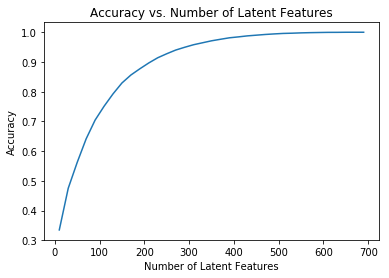

In [52]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [53]:
df_train = df.head(40000)
df_test = df.tail(5993)

df_train = df_train.drop_duplicates(subset=['user_id', 'article_id'])
df_test = df_test.drop_duplicates(subset=['user_id', 'article_id'])

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
     # Create the user-item matrix for the training set
    user_item_train = df_train.groupby(['user_id', 'article_id'])['title'].count().unstack().notnull().astype(int)
    
    # Create the user-item matrix for the test set
    user_item_test = df_test.groupby(['user_id', 'article_id'])['title'].count().unstack().notnull().astype(int)
    
    # Get the test user ids (index of the test user-item matrix)
    test_idx = user_item_test.index.tolist()
    
    # Get the test article ids (columns of the test user-item matrix)
    test_arts = user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [54]:
def evaluate_predictions(user_item_train, user_item_test):
    '''
    INPUT:
    user_item_train - a user-item matrix of the training dataframe
    user_item_test - a user-item matrix of the testing dataframe
    
    OUTPUT:
    answers - a dictionary with the following keys and their corresponding counts:
              'number_of_users_in_test_with_predictions' - Number of users in test set with interactions in training set
              'number_of_users_in_test_no_predictions' - Number of users in test set without interactions in training set
              'number_of_articles_in_test_with_predictions' - Number of articles in test set with interactions in training set
              'number_of_articles_in_test_no_predictions' - Number of articles in test set without interactions in training set
    '''
    # Users in the test set
    test_users = user_item_test.index
    # Articles in the test set
    test_articles = user_item_test.columns
    
    # Users with interactions in the training set
    train_users = user_item_train.index
    # Articles with interactions in the training set
    train_articles = user_item_train.columns
    
    # Number of users in the test set with interactions in the training set
    users_with_predictions = test_users[test_users.isin(train_users)]
    number_of_users_with_predictions = len(users_with_predictions)
    
    # Number of users in the test set without interactions in the training set
    users_without_predictions = test_users[~test_users.isin(train_users)]
    number_of_users_without_predictions = len(users_without_predictions)
    
    # Number of articles in the test set with interactions in the training set
    articles_with_predictions = test_articles[test_articles.isin(train_articles)]
    number_of_articles_with_predictions = len(articles_with_predictions)
    
    # Number of articles in the test set without interactions in the training set
    articles_without_predictions = test_articles[~test_articles.isin(train_articles)]
    number_of_articles_without_predictions = len(articles_without_predictions)
    
    answers = {
        'number_of_users_in_test_with_predictions': number_of_users_with_predictions,
        'number_of_users_in_test_no_predictions': number_of_users_without_predictions,
        'number_of_articles_in_test_with_predictions': number_of_articles_with_predictions,
        'number_of_articles_in_test_no_predictions': number_of_articles_without_predictions
    }
    
    return answers

# Example usage:
answers = evaluate_predictions(user_item_train, user_item_test)
print(answers)


{'number_of_users_in_test_with_predictions': 20, 'number_of_users_in_test_no_predictions': 662, 'number_of_articles_in_test_with_predictions': 574, 'number_of_articles_in_test_no_predictions': 0}


In [55]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?':b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [56]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [57]:
# First save all user_ids and article_ids of user_item_train matrix for further processing
train_articles =set(user_item_train.columns) 
train_idx = set(user_item_train.index)

# Find now the overlapping users in train_idx and test_idx
overlap_idx = list(train_idx.intersection(test_idx))

# Find now the overlapping articles in train_arts and test_arts
overlap_cols = list(train_articles.intersection(test_arts)) 

# Find the subset of the user_item_test based on the overlapping users and articles
user_item_test = user_item_test.loc[overlap_idx,overlap_cols] 

# Define the new u_test
row_idxs = user_item_train.index.isin(test_idx)
u_test = u_train[row_idxs, :]

# Define the new vt_test
col_idxs = user_item_train.columns.isin(test_arts)
vt_test = vt_train[:,col_idxs]

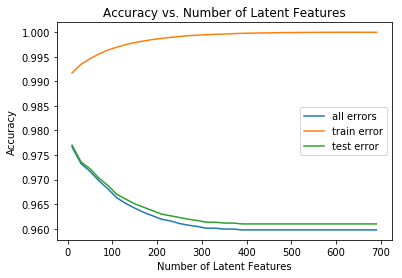

In [58]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []
all_errs = []
for k in num_latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat =  u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
                                
    
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
    
    # compute error for each prediction to actual value    
    diffs_train = np.subtract(user_item_train, user_item_train_preds)  ###
 #   diffs_test = np.subtract(overlap_df, user_item_test_preds)
    diffs_test = np.subtract(user_item_test, user_item_test_preds)
    
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
plt.plot(num_latent_feats,   all_errs,label = 'all errors')
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_train.shape[1]),label = 'train error');  ###
plt.plot(num_latent_feats,  1 - np.array(sum_errs_test)/(user_item_test.shape[0]* user_item_test.shape[1]),label = 'test error');   ###
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

As shown in the diagram, the accuracy decreases as the number of latent features increases. With only 20 users present in both the training and testing datasets, there's limited data available to evaluate how well the predictions made by collaborative filtering with SVD align with actual outcomes. While the plot above suggests high accuracy, this is primarily due to the class imbalance between 1s and 0s.

An alternative approach to the offline method we've been using is to implement an online strategy to assess the effectiveness of different recommendation systems. For example, an A/B test could be conducted to compare a rank-based recommendation system with a matrix-based one. Implement an A/B test where a portion of users receives recommendations from the SVD model, while another portion continues to use the current recommendation system. By comparing key metrics such as click-through rate, time spent on recommended articles, and conversion rates, you can assess which system performs better.


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [59]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0